In [32]:
!pip install pandas scikit-learn matplotlib seaborn streamlit joblib



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


In [2]:
# Load CSV file
df = pd.read_csv("./WELFake_Dataset.csv")

# Drop the index column (assuming it's unnamed or named something like "Unnamed: 0")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Display the first few rows
df.head()


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
# Combine title and text into one feature column
df['content'] = df['title'] + " " + df['text']

# Check for null values
print(df.isnull().sum())

# Drop rows with missing values (if any)
df = df.dropna()

# Features and labels
X = df['content']
y = df['label']


title      558
text        39
label        0
content    597
dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [10]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [11]:
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9475817724350014

Confusion Matrix:
 [[6636  445]
 [ 305 6922]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      7081
           1       0.94      0.96      0.95      7227

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



In [13]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["True", "Fake"], yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'y_pred' is not defined

In [13]:
def predict_news_LR(news_title, news_text):
    content = news_title + " " + news_text
    content_tfidf = vectorizer.transform([content])
    prediction = model.predict(content_tfidf)
    probability = model.predict_proba(content_tfidf)

    return {
        "prediction": "Fake" if prediction[0] == 1 else "Real",
        "probability": round(probability[0][prediction[0]] * 100, 2)
    }


In [14]:
result = predict_news_LR(
    "NASA finds alien city on moon!",
    """In a shocking discovery, NASA scientists confirmed a hidden alien city buried beneath the surface of the Moon's south pole. Using high-resolution radar imaging from the Artemis orbital probe, researchers detected symmetrical structures and geometric patterns inconsistent with natural formations. Initial analysis suggests the presence of metallic compounds not found in any known Earth or lunar materials. Dr. Elaine Foster, the lead astrophysicist on the project, described the discovery as "a potential paradigm shift in our understanding of extraterrestrial life." NASA is reportedly coordinating with international space agencies for a joint manned mission to investigate the site further. While the official report remains classified, leaked footage and internal memos have ignited a global storm of speculation and conspiracy theories."""

)

print(f"Prediction: {result['prediction']} ({result['probability']}% confidence)")


Prediction: Fake (81.78% confidence)


In [15]:
result = predict_news_LR(
    "Modi's manifesto includes occupation of Kashmir: Shazia Marri",
    """Pakistan People's Party (PPP) MNA Shazia Marri slammed Narendra Modi's actions during a National Aseembly session on Thursday.

Modi's manifesto includes occupation of Kashmir and narrowing the land for minorities there. Prime Minister Shehbaz Sharif clearly said that we have no role in the Pahalgam incident, said Marri.

She also lauded the brave efforts of Pakistan Army and added: "250 million people of Pakistan stand shoulder to shoulder with their brave soldiers."

"""

)

print(f"Prediction: {result['prediction']} ({result['probability']}% confidence)")


Prediction: Real (51.49% confidence)


In [16]:
result = predict_news_LR(
    "Postecoglou's Spurs career depends on one result",
    """
    Postecoglou's comments about winning a trophy in his second season looked like they might come back to haunt him at times, but he is now just one game away from delivering the goods.

"Be careful what you dream for," former Spurs midfielder Glenn Hoddle told TNT Sports.

"He has come out and said it and his players have come out and responded. He's saying 'I always win something in my second season' and he believes it, the players are believing it and now the fans are believing it. Anything can happen."

Former Tottenham goalkeeper Paul Robison, part of the BBC 's commentary team in Norway, believes winning the Europa League is more important to Postecoglou than it is to Manchester United boss Ruben Amorim.

"If Tottenham don't win he won't be in charge next season," Robinson said.

"Ange Postecoglou's whole season and Tottenham career depends on that one result. You cannot underestimate how big that game is for Tottenham to win the final.

"Champions League football, yes, and the finances that come with it, but not having to go through a whole restructure. If they don't win that final they are back to square one. It's massive for Tottenham.
"""

)

print(f"Prediction: {result['prediction']} ({result['probability']}% confidence)")


Prediction: Real (59.79% confidence)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC()
calibrated_svc = CalibratedClassifierCV(svc)  # default is sigmoid calibration
calibrated_svc.fit(X_train_tfidf, y_train)

# Now you can use:
svm_pred = calibrated_svc.predict(X_test_tfidf)
probs = calibrated_svc.predict_proba(X_test_tfidf)


In [15]:
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nSVM Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, svm_pred))

SVM Accuracy: 0.9621889851831144

SVM Confusion Matrix:
 [[6788  293]
 [ 248 6979]]

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      7081
           1       0.96      0.97      0.96      7227

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



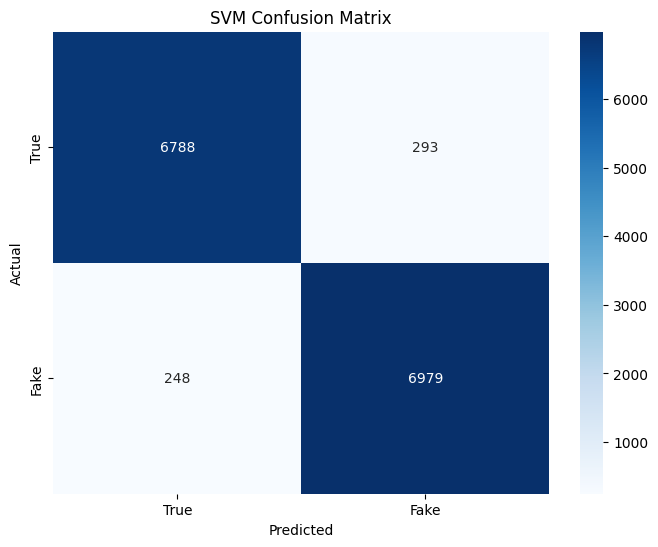

In [14]:
conf_mat_svm = confusion_matrix(y_test, svm_pred)
import seaborn as sns
plt.figure(figsize=(8, 6))

sns.heatmap(conf_mat_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["True", "Fake"], yticklabels=["True", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

In [ ]:
def predict_news_SVM(news_title, news_text):
    content = news_title + " " + news_text
    content_tfidf = vectorizer.transform([content])
    prediction = svm_model.predict(content_tfidf)
    # probability = svm_model.predict_proba(content_tfidf)
    return {
        "prediction": "Fake" if prediction[0] == 1 else "Real",
    }


In [28]:
result = predict_news_SVM(
    "NASA finds alien city on moon!",
    """In a shocking discovery, NASA scientists confirmed a hidden alien city buried beneath the surface of the Moon's south pole. Using high-resolution radar imaging from the Artemis orbital probe, researchers detected symmetrical structures and geometric patterns inconsistent with natural formations. Initial analysis suggests the presence of metallic compounds not found in any known Earth or lunar materials. Dr. Elaine Foster, the lead astrophysicist on the project, described the discovery as "a potential paradigm shift in our understanding of extraterrestrial life." NASA is reportedly coordinating with international space agencies for a joint manned mission to investigate the site further. While the official report remains classified, leaked footage and internal memos have ignited a global storm of speculation and conspiracy theories."""

)

print(f"Prediction: {result['prediction']}")


Prediction: Fake


In [29]:
result = predict_news_SVM(
    "Postecoglou's Spurs career depends on one result",
    """
    Postecoglou's comments about winning a trophy in his second season looked like they might come back to haunt him at times, but he is now just one game away from delivering the goods.

"Be careful what you dream for," former Spurs midfielder Glenn Hoddle told TNT Sports.

"He has come out and said it and his players have come out and responded. He's saying 'I always win something in my second season' and he believes it, the players are believing it and now the fans are believing it. Anything can happen."

Former Tottenham goalkeeper Paul Robison, part of the BBC 's commentary team in Norway, believes winning the Europa League is more important to Postecoglou than it is to Manchester United boss Ruben Amorim.

"If Tottenham don't win he won't be in charge next season," Robinson said.

"Ange Postecoglou's whole season and Tottenham career depends on that one result. You cannot underestimate how big that game is for Tottenham to win the final.

"Champions League football, yes, and the finances that come with it, but not having to go through a whole restructure. If they don't win that final they are back to square one. It's massive for Tottenham.
"""

)

print(f"Prediction: {result['prediction']} ")


Prediction: Real 


In [31]:
import streamlit as st

# Assuming you have defined and imported the following functions:
# - predict_news_SVM(title, text)
# - predict_news_LR(title, text)

st.set_page_config(page_title="Fake News Classifier", layout="centered")

st.title("📰 Fake News Detection App")
st.subheader("Classify news articles using ML models")

# Input Fields
title = st.text_input("Enter the news title")
text = st.text_area("Enter the news content")

# Prediction Result Placeholder
result = None

# Prediction Buttons
col1, col2 = st.columns(2)

with col1:
    if st.button("Predict using SVM"):
        if title.strip() and text.strip():
            pred = predict_news_SVM(title, text)
            result = f"Prediction using SVM: **{pred['prediction']}** ({pred['probability']}% confidence)"
        else:
            st.warning("Please fill both title and text fields.")

with col2:
    if st.button("Predict using Logistic Regression"):
        if title.strip() and text.strip():
            pred = predict_news_LR(title, text)
            result = f"Prediction using Logistic Regression: **{pred['prediction']}** ({pred['probability']}% confidence)"
        else:
            st.warning("Please fill both title and text fields.")

# Display Result
if result:
    st.markdown("---")
    st.success(result)


2025-05-09 19:06:58.812 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-09 19:06:58.813 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-09 19:06:59.007 
  command:

    streamlit run C:\Users\PMLS\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-09 19:06:59.008 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-09 19:06:59.008 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-09 19:06:59.009 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-09 19:06:59.009 Thread 'MainThread': missing ScriptRunContext! This warning can be

In [16]:
import joblib
# Save the model and vectorizer
# joblib.dump(model, 'logistic_regression_model.pkl')
# joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(calibrated_svc, 'svm_model.pkl')


['svm_model.pkl']